https://pubmed.ncbi.nlm.nih.gov/20369969/
Adams BM, Banks HT, Kwon HD, Tran HT. Dynamic multidrug therapies for hiv: optimal and sti control approaches. Math Biosci Eng. 2004 Sep;1(2):223-41. doi: 10.3934/mbe.2004.1.223. PMID: 20369969.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from hiv_patient import HIVPatient

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from collections import deque
from joblib import dump, load

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from IPython import display

import gym

%matplotlib inline

<ipython-input-1-ea3e37fab2b1>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Utils

In [2]:
def plot_reward(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period, "episode moving avg", moving_avg[-1])
    display.clear_output(wait=True)
    
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [3]:
def choose_action(state, policy, EPS=0.15, INIT=False, DISPLAY=False):
    if (np.random.random() > EPS) and not(INIT):
        all_Q = policy(state)
        if DISPLAY:
            print(all_Q)
        next_action = all_Q.argmax()
        return next_action
    else:
        return np.random.randint(0, N_ACTION)

In [4]:
N_ACTION = 4
DIM_STATE = 6

In [5]:
class ReplayBuffer:
    def __init__(self, maxlen=60_000):
        super().__init__()
        self.maxlen = maxlen
        self.buffer = deque(maxlen=maxlen)
        
    def fill_buffer(self, env, nb_initial):
        s = env.reset()
        for i in tqdm(range(nb_initial)):    
            action = choose_action(s, None, INIT=True)
            new_s, r, d, _ = env.step(action)

            one_hot_action = np.zeros(N_ACTION)
            one_hot_action[action] = 1

            new_item = (s, one_hot_action, r, new_s, d)
            self.append(new_item)

            s = new_s
            
            if d:
                s = env.reset()
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def append(self, new_item):
        self.buffer.append(new_item)
        
    def drop(self):
        self.buffer = deque(maxlen=self.maxlen)
        
    def __repr__(self):
        return f"<ReplayBuffer : {len(self.buffer)} items>"
    
    def __len__(self):
        return len(self.buffer)
    

# Random

In [9]:
env = HIVPatient(clipping=False, logscale=False)
s = env.reset()
s[5] *= .75
env.E *= .75
print(env.E)
dur = 80 # 400/5
nb_steps = int(dur // 1e-3)
states = [s]
for i in tqdm(range(dur)):
    action = np.random.randint(0, 4)
    s, r, d, _ = env.step(action)
    states.append(s)

18.0


  0%|          | 0/80 [00:00<?, ?it/s]

Text(0.5, 1.0, 'E')

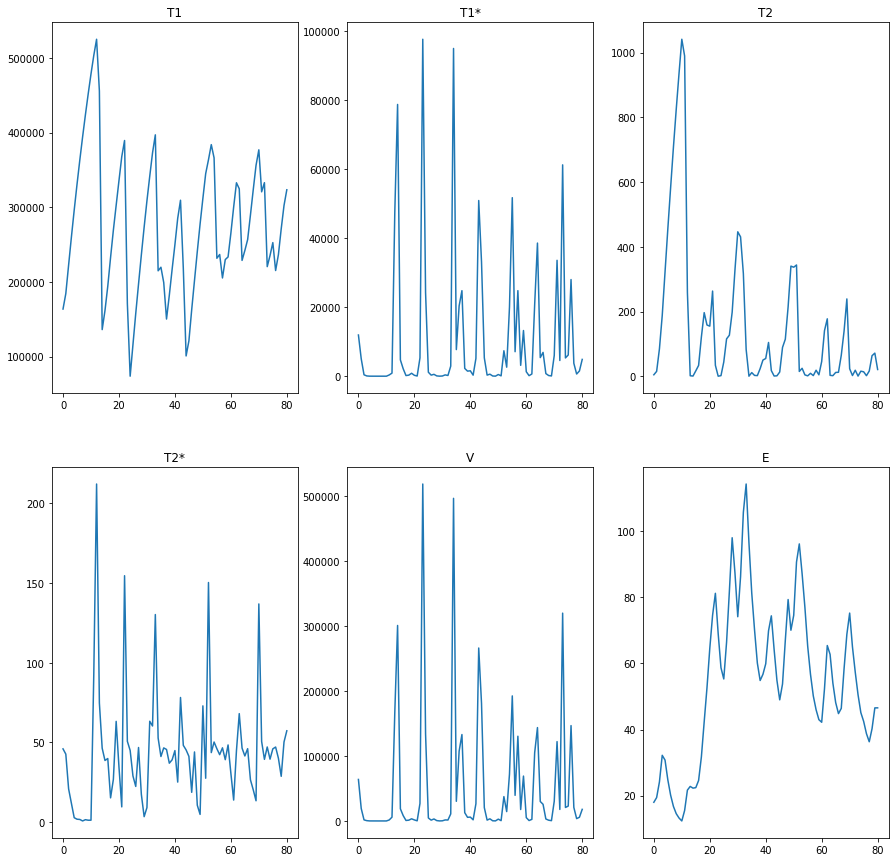

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(15, 15))
npst = np.array(states)
axs[0,0].plot(npst[:,0])
axs[0,0].set_title("T1")
axs[0,1].plot(npst[:,1])
axs[0,1].set_title("T1*")
axs[0,2].plot(npst[:,2])
axs[0,2].set_title("T2")
axs[1,0].plot(npst[:,3])
axs[1,0].set_title("T2*")
axs[1,1].plot(npst[:,4])
axs[1,1].set_title("V")
axs[1,2].plot(npst[:,5])
axs[1,2].set_title("E")

# Fitted Q-iteration

In [6]:
# env = gym.make('CartPole-v1')
# N_ACTION = env.action_space.n
# DIM_STATE = env.observation_space.shape[0]
# env.reset()

In [7]:
env = HIVPatient(clipping=False, logscale=False)
N_ACTION = len(env.action_set)
DIM_STATE = len(env.state())
env.reset()

array([1.63573e+05, 1.19450e+04, 5.00000e+00, 4.60000e+01, 6.39190e+04,
       2.40000e+01])

In [8]:
nb_initial = 1000

replay_buffer = ReplayBuffer()
replay_buffer.fill_buffer(env, nb_initial)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
class HQIAgent:
    def __init__(self):
        super().__init__()
        self.model = RandomForestRegressor()
        self.gamma = 0.98
        
    def train(self, replay_buffer, INIT=False):
        len_buffer = len(replay_buffer)
        buffer = replay_buffer.sample(len_buffer)
        print(f"----- Training on {len_buffer} samples")

        X = np.zeros((len_buffer, N_ACTION + DIM_STATE))
        y = np.zeros((len_buffer))

        x = np.zeros((len_buffer, DIM_STATE))
        r = np.zeros((len_buffer, 1))

        for i, item in enumerate(buffer):
            X[i] = np.concatenate([item[0], item[1]])
            x[i] = item[0]
            r[i] = item[2]

        if INIT:
            maxQ = np.zeros((len_buffer, 1))
        else:
            # xa = [[state@action1], [state@action2] ...] de dimension (len_buffer, 10)
            xa = np.zeros((len_buffer * N_ACTION, N_ACTION + DIM_STATE))
            xa[:, :DIM_STATE] = np.repeat(x, N_ACTION, axis=0)
            xa[:, DIM_STATE:] = np.tile(np.eye(N_ACTION), reps=(len_buffer, 1))

            # all_Q = [Q(state, action1), Q(state, action2)] de dimension (len_buffer, 1)
            all_Q = self.model.predict(xa)
            all_Q = all_Q.reshape((len_buffer, -1))

            maxQ = np.max(all_Q, axis=1).reshape(len_buffer, 1)
            
        
        y = (r + self.gamma * maxQ).ravel()
        
        self.model.fit(X, y)

        
    def predict(self, state):
        xa = [np.concatenate((s, a)) for a in np.eye(N_ACTION)]
        all_Q = self.model.predict(xa)
        return all_Q
        
    def __call__(self, state):
        return self.predict(state)
    
    def save(self, filename='model.policy'):
        dump(policy.model, filename) 
    
    def load(self, filename='model.policy'):
        self.model = load(filename) 
        print(f"Model loaded from {filename}")

In [10]:
hqi_agent = HQIAgent()
hqi_agent.train(replay_buffer, INIT=True)

----- Training on 1000 samples


In [13]:
nb_iteration = 1000
train_every = 80*3
reset_every = 80
sum_reward = 0

for iteration in tqdm(range(nb_iteration)):
    if iteration % reset_every == 0 or d:
        print(sum_reward)
        sum_reward = 0
        s = env.reset()
    
    action = choose_action(s, hqi_agent, INIT=False)
    new_s, r, d, _ = env.step(action)
    
    sum_reward += r
    
    one_hot_action = np.zeros(N_ACTION)
    one_hot_action[action] = 1
    
    new_item = (s, one_hot_action, r, new_s)
    replay_buffer.append(new_item)
    
    s = new_s
    
    if iteration % train_every == 0 and iteration > 0:
        hqi_agent.train(replay_buffer, INIT=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

0
1504980.4946837653
1674323.4233500003
1719342.610442039
----- Training on 6241 samples
1570411.8505597664
1483925.015646939
1539390.9382585408
----- Training on 6481 samples
1858609.1474629985
1957432.0858284405
1587341.3425923197
----- Training on 6721 samples
1574958.7532894008
1743473.9800500446
1716065.9774185293
----- Training on 6961 samples


In [ ]:
hqi_agent.save()

In [14]:
# x = env.reset()
# env.render()
# for i in range(1000):
#     a = choose_action(x, hqi_agent, INIT=False, EPS=0, DISPLAY=True)
#     print(a)
#     y, _, d, _ = env.step(a)
#     env.render()
#     x = y
#     if d:
#         print(i)
#         break

# env.close()

In [18]:
s = env.reset('unhealthy')
# s = env.reset("healthy")
# s = env.reset("uninfected")


s[5] *= .75
env.E *= .75
print(env.E)
dur = 80 # 400/5
states = [s]
rewards = [0]

for i in tqdm(range(dur)):
    action = choose_action(s, hqi_agent, INIT=False, EPS=0, DISPLAY=False)
#     print(action, end=' ')
    s, r, d, _ = env.step(action)
    rewards.append(r)
    states.append(s)

18.0


  0%|          | 0/80 [00:00<?, ?it/s]

Text(0.5, 1.0, 'E')

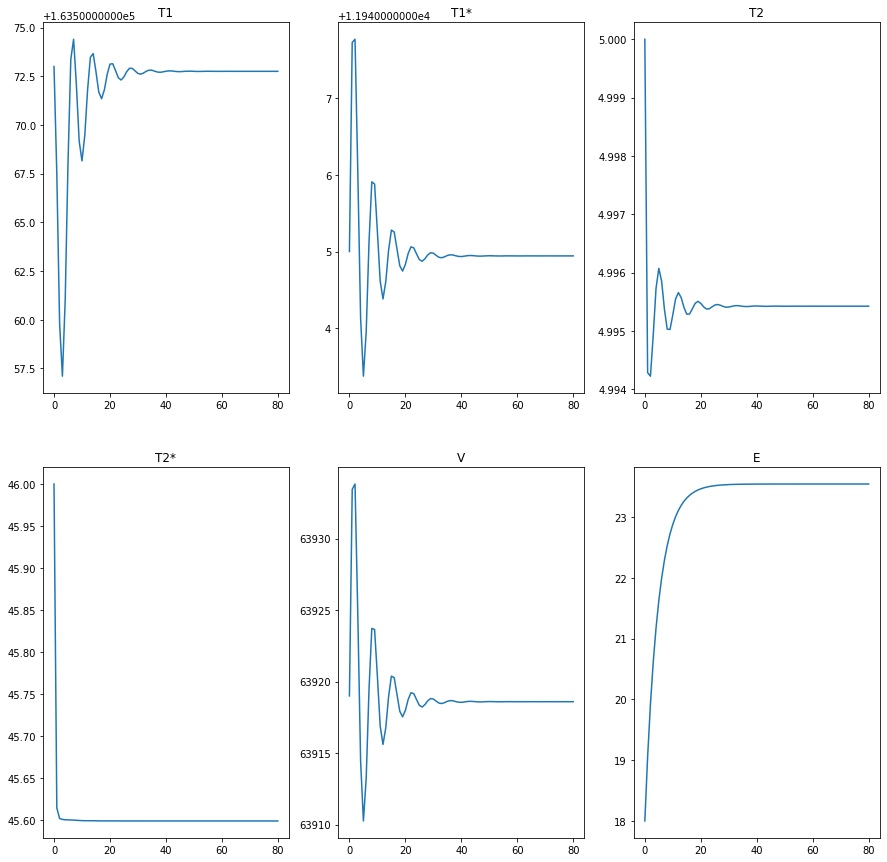

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(15, 15))
# for ax in axs.ravel():
#     ax.set_yscale('log')
npst = np.array(states)
axs[0,0].plot(npst[:,0])
axs[0,0].set_title("T1")
axs[0,1].plot(npst[:,1])
axs[0,1].set_title("T1*")
axs[0,2].plot(npst[:,2])
axs[0,2].set_title("T2")
axs[1,0].plot(npst[:,3])
axs[1,0].set_title("T2*")
axs[1,1].plot(npst[:,4])
axs[1,1].set_title("V")
axs[1,2].plot(npst[:,5])
axs[1,2].set_title("E")

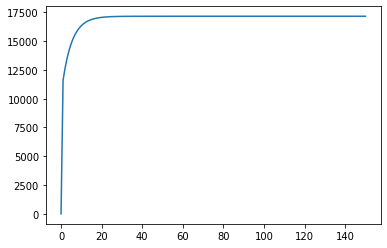

In [17]:
plt.plot(rewards);

**Load**

In [ ]:
hqi_agent = HQIAgent()
hqi_agent.load('model1.policy')

# DQN

In [129]:
env = gym.make('CartPole-v1')
N_ACTION = env.action_space.n
DIM_STATE = env.observation_space.shape[0]
env.reset()

array([ 0.00114711,  0.01616015, -0.01453092,  0.0065846 ])

In [130]:
# env = HIVPatient(clipping=False, logscale=False)
# N_ACTION = len(env.action_set)
# DIM_STATE = len(env.state())
# env.reset()

In [131]:
class DenseNet(nn.Module):
    # Rq : ici, on donne l'état en entrée, et pour toutes les actions, son Q correspondant, contrairement au RF
    def __init__(self, IN_DIM=DIM_STATE, OUT_DIM=N_ACTION):
        super().__init__()
        self.fc1 = nn.Linear(IN_DIM, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, OUT_DIM)
        
    def forward(self, x):
        batch_size = x.shape[0]
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DQN = DenseNet().to(device)

In [133]:
replay_buffer_size = 6_000
nb_samples = 1000

memory = ReplayBuffer(replay_buffer_size)
state = env.reset()
for _ in tqdm(range(nb_samples)):
    action = choose_action(state, None, INIT=True)
    next_state, reward, done, _ = env.step(action)
    new_item = (state, action, reward, next_state, done)
    memory.append(new_item)
    if done:
        state = env.reset()
    else:
        state = next_state

  0%|          | 0/1000 [00:00<?, ?it/s]

In [134]:
class DQN_agent:
    def __init__(self, config, model):
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.nb_actions = config['nb_actions']
        self.memory = ReplayBuffer(config['buffer_size'])
        self.epsilon_max = config['epsilon_max']
        self.epsilon_min = config['epsilon_min']
        self.epsilon_stop = config['epsilon_decay_period']
        self.epsilon_delay = config['epsilon_delay_decay']
        self.epsilon_step = (self.epsilon_max - self.epsilon_min) / self.epsilon_stop
        self.total_steps = 0
        self.model = model 
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=config['learning_rate'])
        self.reset_every = config['reset_every']
        self.plot = config['plot']
    
    
    def make_training_data(self):
        batch = self.memory.sample(self.batch_size)
        X, A, R, Y, D = [], [], [], [], []
        for sample in batch:
            X.append(sample[0])
            A.append(sample[1])
            R.append(sample[2])
            Y.append(sample[3])
            D.append(sample[4])
            
        return torch.Tensor(X), torch.Tensor(A), torch.Tensor(R), torch.Tensor(Y), torch.Tensor(D)
    
    
    def gradient_step(self):
        if len(self.memory) > self.batch_size:
            X, A, R, Y, D = self.make_training_data()
            QYmax = self.model(Y).max(1)[0].detach()
            update = torch.addcmul(R, self.gamma, 1-D, QYmax)
            QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
            loss = self.criterion(QXA, update.unsqueeze(1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
    
    
    def train(self, env, max_episode):
        episode_return = []
        episode = 0
        episode_cum_reward = 0
        state = env.reset()
        epsilon = self.epsilon_max
        step = 0
        
        
        while episode < max_episode:
            # update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon-self.epsilon_step)

            # select epsilon-greedy action
            action = choose_action(
                torch.Tensor(state).unsqueeze(0).to(device), 
                self.model, EPS=epsilon)
            
            if isinstance(action, torch.Tensor): action = action.item()

            
            # step
            next_state, reward, done, _ = env.step(action)
            new_item = (state, action, reward, next_state, done)
            self.memory.append(new_item)
            episode_cum_reward += reward

            # train
            self.gradient_step()

            # next transition
            step += 1
            
            done = done or (step % self.reset_every == 0)
            
            if done:
                episode += 1
                print("Episode ", '{:3d}'.format(episode), 
                      ", epsilon ", '{:6.2f}'.format(epsilon), 
                      ", batch size ", '{:5d}'.format(len(self.memory)), 
                      ", episode return ", '{:4.1f}'.format(episode_cum_reward),
                      sep='')
                state = env.reset()
                episode_return.append(episode_cum_reward)
                episode_cum_reward = 0
                
                if self.plot:
                    plot_reward(episode_return, 20)
            else:
                state = next_state

        return episode_return

Episode   1, epsilon   1.00, batch size    26, episode return 26.0
Episode   2, epsilon   0.98, batch size    37, episode return 11.0
Episode   3, epsilon   0.97, batch size    52, episode return 15.0
Episode   4, epsilon   0.94, batch size    77, episode return 25.0
Episode   5, epsilon   0.91, batch size   110, episode return 33.0
Episode   6, epsilon   0.90, batch size   119, episode return  9.0
Episode   7, epsilon   0.89, batch size   130, episode return 11.0
Episode   8, epsilon   0.87, batch size   152, episode return 22.0
Episode   9, epsilon   0.85, batch size   168, episode return 16.0
Episode  10, epsilon   0.85, batch size   177, episode return  9.0
Episode  11, epsilon   0.82, batch size   199, episode return 22.0
Episode  12, epsilon   0.81, batch size   211, episode return 12.0
Episode  13, epsilon   0.79, batch size   232, episode return 21.0
Episode  14, epsilon   0.77, batch size   257, episode return 25.0
Episode  15, epsilon   0.74, batch size   280, episode return 

Episode 123, epsilon   0.01, batch size 11484, episode return 201.0
Episode 124, epsilon   0.01, batch size 11664, episode return 180.0
Episode 125, epsilon   0.01, batch size 11835, episode return 171.0
Episode 126, epsilon   0.01, batch size 12012, episode return 177.0
Episode 127, epsilon   0.01, batch size 12349, episode return 337.0
Episode 128, epsilon   0.01, batch size 12519, episode return 170.0
Episode 129, epsilon   0.01, batch size 12717, episode return 198.0
Episode 130, epsilon   0.01, batch size 12895, episode return 178.0
Episode 131, epsilon   0.01, batch size 13075, episode return 180.0
Episode 132, epsilon   0.01, batch size 13223, episode return 148.0
Episode 133, epsilon   0.01, batch size 13387, episode return 164.0
Episode 134, epsilon   0.01, batch size 13558, episode return 171.0
Episode 135, epsilon   0.01, batch size 13736, episode return 178.0
Episode 136, epsilon   0.01, batch size 13925, episode return 189.0
Episode 137, epsilon   0.01, batch size 14110, e

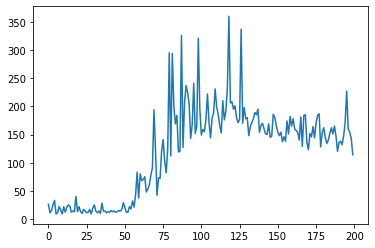

In [135]:
config = {'observation_space': DIM_STATE,
          'nb_actions': N_ACTION,
          'learning_rate': 0.001,
          'gamma': 0.95,
          'buffer_size': 1000000,
          'epsilon_min': 0.01,
          'epsilon_max': 1.,
          'epsilon_decay_period': 1000,
          'epsilon_delay_decay': 20,
          'batch_size': 20,
#           --- HIV
#           'reset_every': 80,
#           'plot': True,
#           --- CartPole
          'reset_every': 1000000,
          'plot' : False
}

agent = DQN_agent(config, DQN)
scores = agent.train(env, 200)
plt.plot(scores)

In [145]:
x = env.reset()
env.render()
for i in range(1000):
    x = torch.Tensor(x)
    a = choose_action(x, DQN, INIT=False, EPS=0, DISPLAY=True).item()
    y, _, d, _ = env.step(a)
    env.render()
    x = y
    if d:
        print(i)
        break

env.close()

tensor([24.1925, 23.4897], grad_fn=<AddBackward0>)
tensor([24.1685, 23.5472], grad_fn=<AddBackward0>)
tensor([24.0652, 23.5797], grad_fn=<AddBackward0>)
tensor([23.8808, 23.5864], grad_fn=<AddBackward0>)
tensor([23.6133, 23.6317], grad_fn=<AddBackward0>)
tensor([23.5930, 23.7169], grad_fn=<AddBackward0>)
tensor([23.5386, 23.7728], grad_fn=<AddBackward0>)
tensor([23.5307, 23.8242], grad_fn=<AddBackward0>)
tensor([23.5578, 23.8583], grad_fn=<AddBackward0>)
tensor([23.8455, 24.1371], grad_fn=<AddBackward0>)
tensor([24.0301, 23.9543], grad_fn=<AddBackward0>)
tensor([24.1071, 24.3170], grad_fn=<AddBackward0>)
tensor([24.3386, 24.2821], grad_fn=<AddBackward0>)
tensor([24.3200, 24.4606], grad_fn=<AddBackward0>)
tensor([24.5956, 24.5604], grad_fn=<AddBackward0>)
tensor([24.5272, 24.6155], grad_fn=<AddBackward0>)
tensor([24.8109, 24.8007], grad_fn=<AddBackward0>)
tensor([24.7387, 24.7917], grad_fn=<AddBackward0>)
tensor([24.9903, 25.0063], grad_fn=<AddBackward0>)
tensor([24.9764, 24.4516], grad

In [21]:
s = env.reset('healthy') # 'uninfected', 'healthy'
s[5] *= .75
env.E *= .75
print(env.E)
dur = 80 # 400/5
states = [s]
rewards = [0]

for i in tqdm(range(dur)):
    s = torch.Tensor(s).unsqueeze(0)
    action = choose_action(s, agent.model, INIT=False, EPS=0, DISPLAY=False)
    print(action, end=' ')
    s, r, d, _ = env.step(action)
    rewards.append(r)
    states.append(s)

264831.0


  0%|          | 0/80 [00:00<?, ?it/s]

tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) tensor(3) 

Text(0.5, 1.0, 'E')

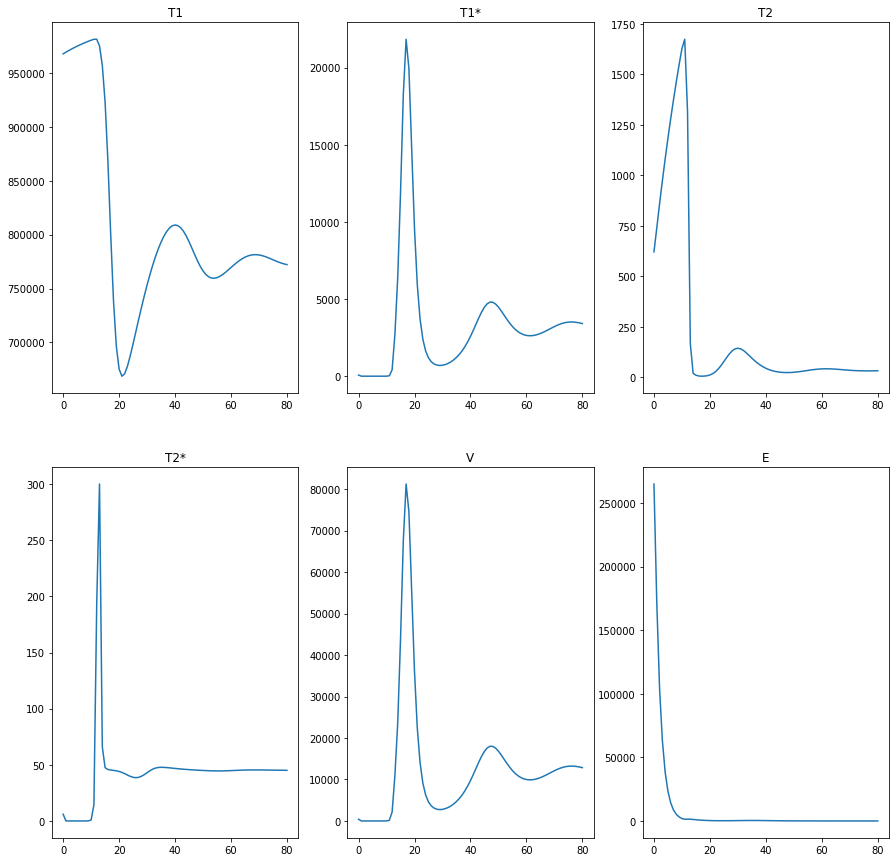

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(15, 15))
npst = np.array(states)
axs[0,0].plot(npst[:,0])
axs[0,0].set_title("T1")
axs[0,1].plot(npst[:,1])
axs[0,1].set_title("T1*")
axs[0,2].plot(npst[:,2])
axs[0,2].set_title("T2")
axs[1,0].plot(npst[:,3])
axs[1,0].set_title("T2*")
axs[1,1].plot(npst[:,4])
axs[1,1].set_title("V")
axs[1,2].plot(npst[:,5])
axs[1,2].set_title("E")

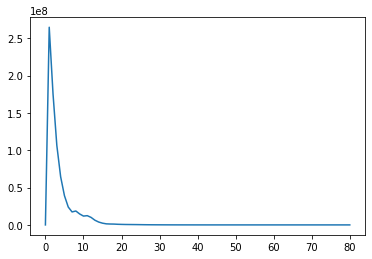

In [302]:
plt.plot(rewards);